In [66]:
%load_ext autoreload
%autoreload 2
# from trim import *
import matplotlib.pyplot as plt
import control
import scipy.linalg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Transport Aircraft Model
Pg 180 for dynamic equations

In [67]:
from transport import *

x = [250, 0, 0, 0, 750*0.3048, 0]   # 
u = [0, 0, 0.25, 1]                 # Landing configuration

In [68]:
res = trim(250,750,0,np.deg2rad(-2.5),land=1, gam_r=np.deg2rad(-3))
res


{'x0': array([ 2.500e+02,  3.823e-03, -3.981e-02,  0.000e+00,  7.500e+02,  0.000e+00]),
 'u0': array([  0.309, -15.218,   0.25 ,   1.   ,  -0.052]),
 's': array([ 3.094e-01, -1.522e+01,  3.823e-03])}

In [69]:
x_dot_check = longitudinal(res['x0'],res['u0'])
x_dot_check #Check for convergence, should be close to zero

SX([2.25785e-10, -1.96646e-08, 0, -1.97446e-09, -10.9048, 2.18163])

In [70]:
# res['u0']
#     thtl = u[0]
#     elev_deg = u[1]
#     xcg = u[2]
#     land = u[3]
#     gam_r = u[4]

In [71]:
sys = linearize(res)
np.set_printoptions(precision=3,linewidth=100)
sys['ss'].A # A matrix should matrix ap pg 335

array([[-3.858e-02,  1.898e+01, -3.214e+01,  0.000e+00,  1.325e-04,  0.000e+00],
       [-1.028e-03, -6.325e-01,  5.613e-03,  1.000e+00,  3.760e-06,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00],
       [ 7.860e-05, -7.591e-01, -7.934e-04, -5.183e-01, -3.085e-07,  0.000e+00],
       [-4.362e-02, -2.498e+02,  2.498e+02,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 8.727e-03, -2.500e+02,  2.500e+02,  0.000e+00,  0.000e+00,  0.000e+00]])

In [72]:
sys['ss'].B #Thrust and Elevator first 2 columns

array([[ 1.010e+01,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [-1.545e-04,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 2.466e-02, -1.077e-02,  6.856e-01,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -2.500e+02]])

In [73]:
sys['u0']

array([  0.309, -15.218,   0.25 ,   1.   ,  -0.052])

In [74]:
G = get_tf(
    sys['ss'].A, sys['ss'].B,
    sys['ss'].C, sys['ss'].D,
    sys['u_id']['thrtl'], sys['y_id']['VT'])
G #This can vary depending on input and output
# This G is Vt/Thrtl transfer function should matches pg 337

TransferFunction(array([ 1.010e+01,  1.162e+01,  1.067e+01, -4.494e-01,  7.906e-03,  0.000e+00]), array([1.   , 1.189, 1.153, 0.058, 0.028, 0.   , 0.   ]))

Controller Design for Automatic Landing

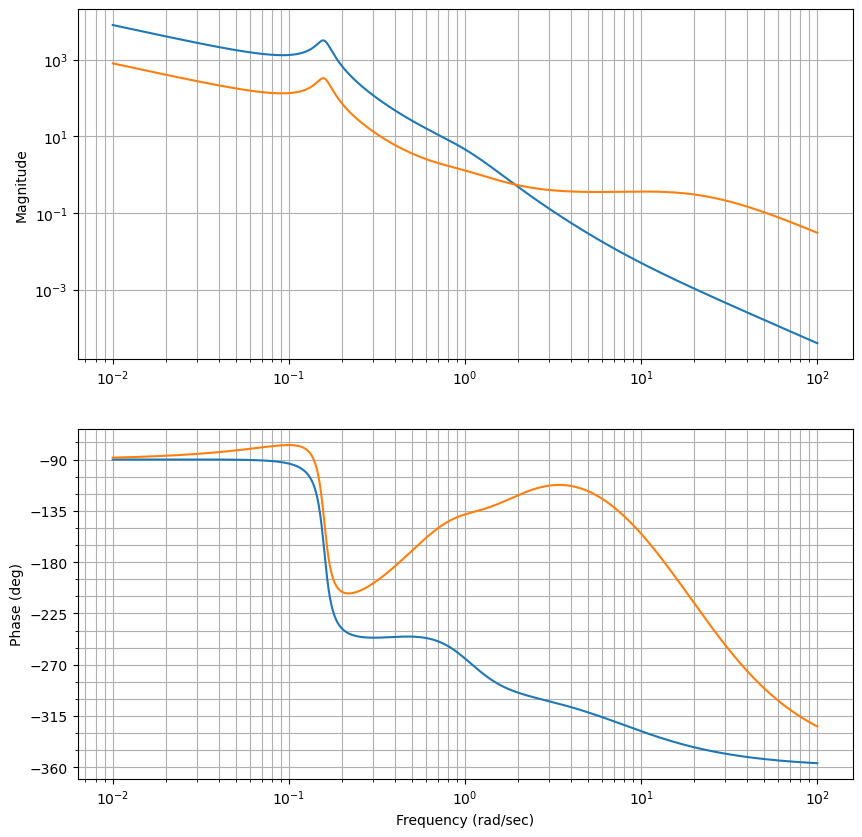

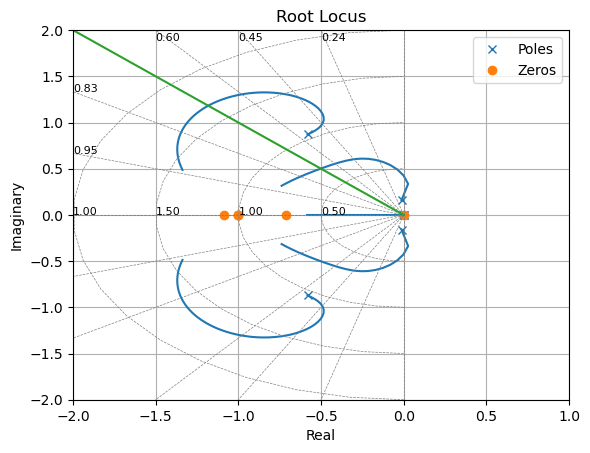

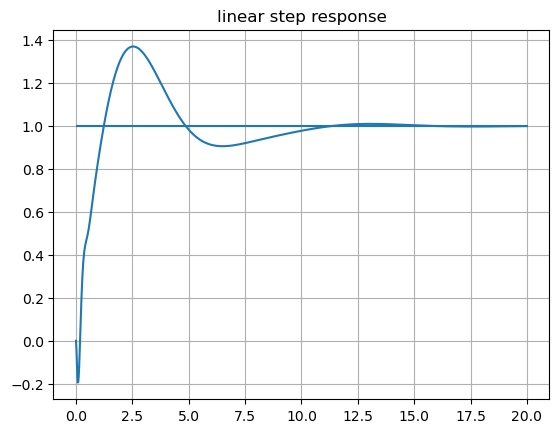

In [84]:
def control_design(operating_point):
    op = operating_point
    G = get_tf(
        op['ss'].A, op['ss'].B,
        op['ss'].C, op['ss'].D,
        op['u_id']['thrtl'], op['y_id']['h'])

    s = control.tf([1, 0], [0, 1])
    H = 0.1*(20*(s+1)/(s+20))**3#-0.17*(s+1)**3*(20/(s+20))**3
    plt.figure(figsize=(10, 10))
    control.bode([G, G*H]);

    plt.figure()
    control.rlocus(G*H, xlim=[-2, 1], ylim=[-2, 2], kvect=np.linspace(0, 100, 1000));
    plt.plot([0, -10], [0, 10])
    plt.grid()
    plt.legend(['Poles','Zeros'])
    
    plt.figure()
    t, y = control.step_response(control.feedback(G*H),
    T = np.linspace(0, 20, 1000))
    plt.hlines(1, t[0], t[-1])
    plt.plot(t, y)
    plt.grid()
    plt.title('linear step response')

    return {
        'H': H
    }

control_data = control_design(sys)